### Filtering Alerts

Here are some examples of filtering alerts based on the packet contents.

In [1]:
import os
import io
import gzip
import tarfile
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import fastavro

from astropy.time import Time
from astropy.io import fits
import astropy.units as u
import aplpy
%matplotlib inline

/Users/ebellm/anaconda3/envs/zads/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Tar archives of ZTF alerts are available from https://ztf.uw.edu/public/alerts.  Let's extract to a directory:

In [2]:
tar_archive = '../data/ztf_public_20180601.tar.gz'
output_dir = tar_archive.split('/')[-1].split('.')[-3]
#archive = tarfile.open(tar_archive,'r:gz')
#archive.extractall(path=output_dir)
#archive.close()

Let's count packets.

In [3]:
def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

In [4]:
print('{} has {} avro files'.format(output_dir, len(list(find_files(output_dir)))))

ztf_public_20180601 has 17991 avro files


In [5]:
def open_avro(fname):
    with open(fname,'rb') as f:
        freader = fastavro.reader(f)
        # in principle there can be multiple packets per file
        for packet in freader:
            yield packet

In [6]:
def generate_dictionaries(root_dir):
    for fname in find_files(root_dir):
        for packet in open_avro(fname):
            yield packet

Let's count the number of observations by program (should all be public!).  Reviewing the [alert packet contents](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html), we want the `programid` field in `candidate`.

In [7]:
%%time
from collections import defaultdict
programs = defaultdict(int)
for packet in generate_dictionaries(output_dir):
    programs[packet['candidate']['programid']] += 1
print(programs)

defaultdict(<class 'int'>, {1: 17991})
CPU times: user 14.4 s, sys: 610 ms, total: 15 s
Wall time: 15.3 s


The alert archive is a fairly raw stream.  Users desiring greater purity can apply the [suggested filters](https://zwickytransientfacility.github.io/ztf-avro-alert/filtering.html):

```
rb >= 0.65 and
nbad = 0 and
fwhm <= 5 and
elong <= 1.2 and
abs(magdiff) <= 0.1
```

In [8]:
def is_alert_pure(packet):
    pure = True
    pure &= packet['candidate']['rb'] >= 0.65
    pure &= packet['candidate']['nbad'] == 0
    pure &= packet['candidate']['fwhm'] <= 5
    pure &= packet['candidate']['elong'] <= 1.2
    pure &= np.abs(packet['candidate']['magdiff']) <= 0.1
    return pure

Let's count the purified packets:

In [9]:
%%time
programs = defaultdict(int)
for packet in filter(is_alert_pure,generate_dictionaries(output_dir)):
    programs[packet['candidate']['programid']] += 1
print(programs)

defaultdict(<class 'int'>, {1: 4375})
CPU times: user 14.9 s, sys: 617 ms, total: 15.5 s
Wall time: 15.7 s


For applications using lightcurves it's useful to have the data in a dataframe, but this construction is somewhat slower, so let's apply it after our initial filter.

In [10]:
def make_dataframe(packet):
    dfc = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    dflc = pd.concat([dfc,df_prv], ignore_index=True)
    # we'll attach some metadata--not this may not be preserved after all operations
    # https://stackoverflow.com/questions/14688306/adding-meta-information-metadata-to-pandas-dataframe
    dflc.objectId = packet['objectId']
    dflc.candid = packet['candid']
    return dflc

Let's use the following cuts to select likely extragalactic transients:

* the difference image detection should be positive
* if there is a PS1 source within 1.5" of the source, it should have a star-galaxy score of < 0.5 (galaxy-like)
* there should be at least two detections separated by more than 30 minutes
* there should be no known solar system object within 5"

In [11]:
def is_transient(dflc):
    
    candidate = dflc.loc[0]
    
    is_positive_sub = candidate['isdiffpos'] == 't'
    
    if (candidate['distpsnr1'] is None) or (candidate['distpsnr1'] > 1.5):
        no_pointsource_counterpart = True
    else:
        if candidate['sgscore1'] < 0.5:
            no_pointsource_counterpart = True
        else:
            no_pointsource_counterpart = False
            
    where_detected = (dflc['isdiffpos'] == 't') # nondetections will be None
    if np.sum(where_detected) >= 2:
        detection_times = dflc.loc[where_detected,'jd'].values
        dt = np.diff(detection_times)
        not_moving = np.max(dt) >= (30*u.minute).to(u.day).value
    else:
        not_moving = False
    
    no_ssobject = (candidate['ssdistnr'] is None) or (candidate['ssdistnr'] < 0) or (candidate['ssdistnr'] > 5)
    
    return is_positive_sub and no_pointsource_counterpart and not_moving and no_ssobject

In [12]:
%%time
transient_alerts = []
for packet in filter(is_alert_pure,generate_dictionaries(output_dir)):
    dflc = make_dataframe(packet)
    if is_transient(dflc):
        print(packet['objectId'])
        transient_alerts.append(packet)

ZTF18aavlkzu
ZTF18aawvbta
ZTF18aasttun
ZTF18aastwrz
ZTF18aahgakg
ZTF18aawacgn
ZTF18aartimj
ZTF18aabylvn
ZTF18aakctzv
ZTF18aauvnhh
ZTF18aavskep
ZTF18aauuqrh
ZTF18aaqfziz
ZTF18aawbjum
ZTF18aahfzea
CPU times: user 1min 34s, sys: 1.33 s, total: 1min 35s
Wall time: 1min 37s


Now let's do the same thing and make plots instead:

In [13]:
def plot_lightcurve(dflc, ax=None, days_ago=True):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    if ax is None:
        plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.',color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    plt.title(dflc.objectId)
    

In [14]:
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            if fig is None:
                fig = plt.figure(figsize=(4,4))
            if subplot is None:
                subplot = (1,1,1)
            ffig = aplpy.FITSFigure(hdul[0],figure=fig, subplot=subplot, **kwargs)
            ffig.show_grayscale(stretch='arcsinh')
    return ffig

Now let's make a nice helper function:

In [15]:
def show_stamps(packet):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    fig = plt.figure(figsize=(12,4))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)

In [16]:
def show_all(packet):
    fig = plt.figure(figsize=(16,4))
    dflc = make_dataframe(packet)
    plot_lightcurve(dflc,ax = plt.subplot(1,4,1))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,4,i+2))
        ffig.set_title(cutout)

INFO:astropy:Auto-setting vmin to  2.555e+02
INFO:astropy:Auto-setting vmax to  3.748e+03


INFO: Auto-setting vmin to  2.555e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.748e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.820e+02
INFO:astropy:Auto-setting vmax to  3.552e+03


INFO: Auto-setting vmin to  2.820e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.552e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to -1.449e+02
INFO:astropy:Auto-setting vmax to  1.812e+02


INFO: Auto-setting vmin to -1.449e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.812e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.091e+02
INFO:astropy:Auto-setting vmax to  4.653e+03


INFO: Auto-setting vmin to  1.091e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.653e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.389e+02
INFO:astropy:Auto-setting vmax to  5.186e+03


INFO: Auto-setting vmin to  1.389e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.186e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to -8.574e+01
INFO:astropy:Auto-setting vmax to  2.853e+02


INFO: Auto-setting vmin to -8.574e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.853e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.439e+02
INFO:astropy:Auto-setting vmax to  4.671e+02


INFO: Auto-setting vmin to  2.439e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.671e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.602e+02
INFO:astropy:Auto-setting vmax to  4.472e+02


INFO: Auto-setting vmin to  2.602e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.472e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -2.178e+01
INFO:astropy:Auto-setting vmax to  2.494e+01


INFO: Auto-setting vmin to -2.178e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.494e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.106e+02
INFO:astropy:Auto-setting vmax to  4.541e+02


INFO: Auto-setting vmin to  2.106e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.541e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.265e+02
INFO:astropy:Auto-setting vmax to  4.235e+02


INFO: Auto-setting vmin to  2.265e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.235e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -1.962e+01
INFO:astropy:Auto-setting vmax to  2.297e+01


INFO: Auto-setting vmin to -1.962e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.297e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.863e+02
INFO:astropy:Auto-setting vmax to  3.152e+03


INFO: Auto-setting vmin to  1.863e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.152e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.001e+02
INFO:astropy:Auto-setting vmax to  3.368e+03


INFO: Auto-setting vmin to  2.001e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.368e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to -9.532e+01
INFO:astropy:Auto-setting vmax to  5.644e+01


INFO: Auto-setting vmin to -9.532e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.644e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  8.986e+01
INFO:astropy:Auto-setting vmax to  1.196e+03


INFO: Auto-setting vmin to  8.986e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.196e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.214e+02
INFO:astropy:Auto-setting vmax to  1.376e+03


INFO: Auto-setting vmin to  1.214e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.376e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to -5.145e+01
INFO:astropy:Auto-setting vmax to  8.615e+01


INFO: Auto-setting vmin to -5.145e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.615e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.463e+02
INFO:astropy:Auto-setting vmax to  4.819e+02


INFO: Auto-setting vmin to  1.463e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.819e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.731e+02
INFO:astropy:Auto-setting vmax to  4.678e+02


INFO: Auto-setting vmin to  1.731e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.678e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -3.108e+01
INFO:astropy:Auto-setting vmax to  3.838e+01


INFO: Auto-setting vmin to -3.108e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.838e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.946e+02
INFO:astropy:Auto-setting vmax to  3.230e+03


INFO: Auto-setting vmin to  1.946e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.230e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.091e+02
INFO:astropy:Auto-setting vmax to  3.457e+03


INFO: Auto-setting vmin to  2.091e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.457e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to -3.605e+01
INFO:astropy:Auto-setting vmax to  4.201e+02


INFO: Auto-setting vmin to -3.605e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.201e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.613e+02
INFO:astropy:Auto-setting vmax to  4.859e+02


INFO: Auto-setting vmin to  2.613e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.859e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.757e+02
INFO:astropy:Auto-setting vmax to  4.468e+02


INFO: Auto-setting vmin to  2.757e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.468e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -1.854e+01
INFO:astropy:Auto-setting vmax to  2.174e+01


INFO: Auto-setting vmin to -1.854e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.174e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.325e+02
INFO:astropy:Auto-setting vmax to  3.162e+02


INFO: Auto-setting vmin to  1.325e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.162e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.616e+02
INFO:astropy:Auto-setting vmax to  2.623e+02


INFO: Auto-setting vmin to  1.616e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.623e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -3.090e+01
INFO:astropy:Auto-setting vmax to  4.391e+01


INFO: Auto-setting vmin to -3.090e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.391e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.824e+02
INFO:astropy:Auto-setting vmax to  3.436e+02


INFO: Auto-setting vmin to  1.824e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.436e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.129e+02
INFO:astropy:Auto-setting vmax to  2.596e+02


INFO: Auto-setting vmin to  2.129e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.596e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -3.385e+01
INFO:astropy:Auto-setting vmax to  1.160e+02


INFO: Auto-setting vmin to -3.385e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.160e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.633e+02
INFO:astropy:Auto-setting vmax to  3.865e+02


INFO: Auto-setting vmin to  2.633e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.865e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.793e+02
INFO:astropy:Auto-setting vmax to  3.661e+02


INFO: Auto-setting vmin to  2.793e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.661e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -1.964e+01
INFO:astropy:Auto-setting vmax to  2.602e+01


INFO: Auto-setting vmin to -1.964e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.602e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.397e+02
INFO:astropy:Auto-setting vmax to  4.648e+02


INFO: Auto-setting vmin to  1.397e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.648e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.633e+02
INFO:astropy:Auto-setting vmax to  4.839e+02


INFO: Auto-setting vmin to  1.633e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.839e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -2.992e+01
INFO:astropy:Auto-setting vmax to  3.300e+01


INFO: Auto-setting vmin to -2.992e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.300e+01 [aplpy.core]


INFO:astropy:Auto-setting vmin to  9.602e+01
INFO:astropy:Auto-setting vmax to  1.519e+03


INFO: Auto-setting vmin to  9.602e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.519e+03 [aplpy.core]


INFO:astropy:Auto-setting vmin to  1.271e+02
INFO:astropy:Auto-setting vmax to  8.943e+02


INFO: Auto-setting vmin to  1.271e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.943e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -3.903e+01
INFO:astropy:Auto-setting vmax to  7.588e+02


INFO: Auto-setting vmin to -3.903e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.588e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.300e+02
INFO:astropy:Auto-setting vmax to  5.489e+02


INFO: Auto-setting vmin to  2.300e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.489e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to  2.446e+02
INFO:astropy:Auto-setting vmax to  5.445e+02


INFO: Auto-setting vmin to  2.446e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.445e+02 [aplpy.core]


INFO:astropy:Auto-setting vmin to -1.820e+01
INFO:astropy:Auto-setting vmax to  4.485e+01


INFO: Auto-setting vmin to -1.820e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.485e+01 [aplpy.core]


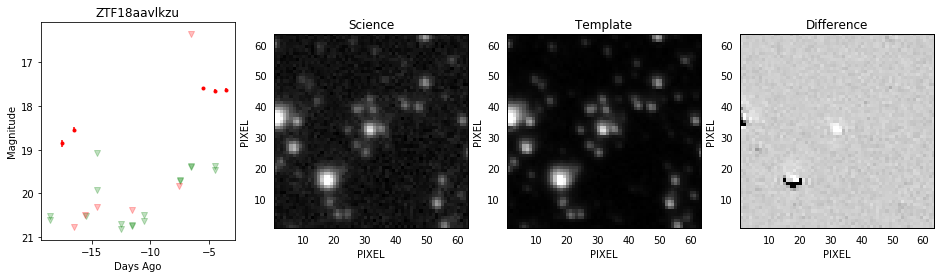

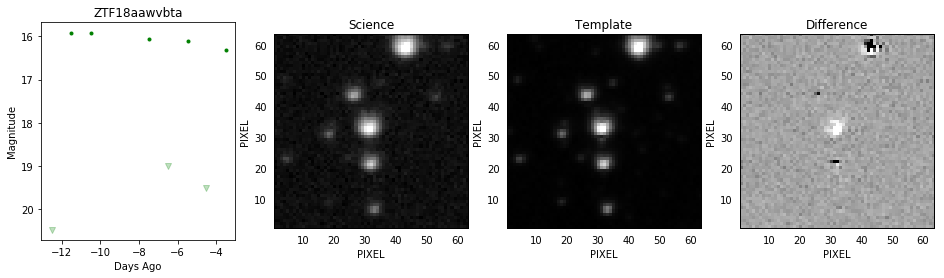

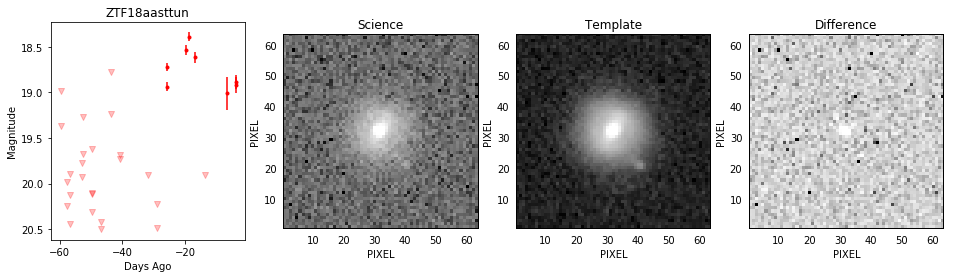

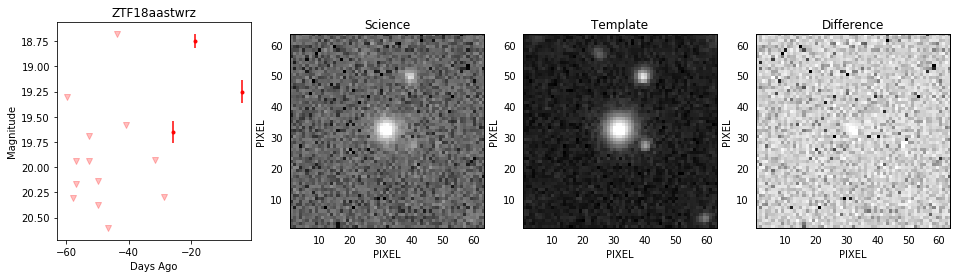

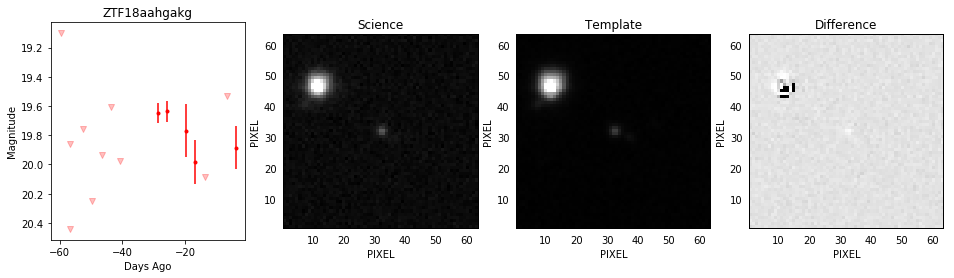

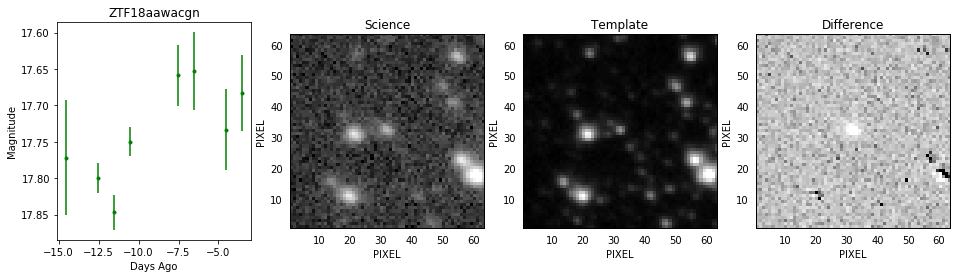

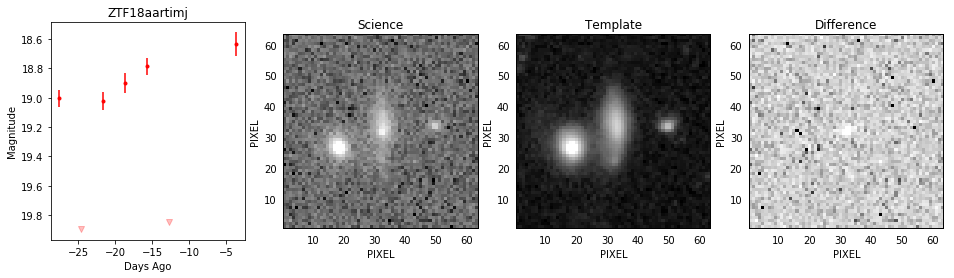

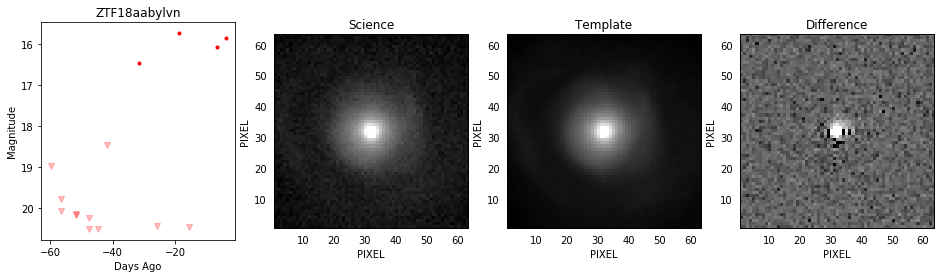

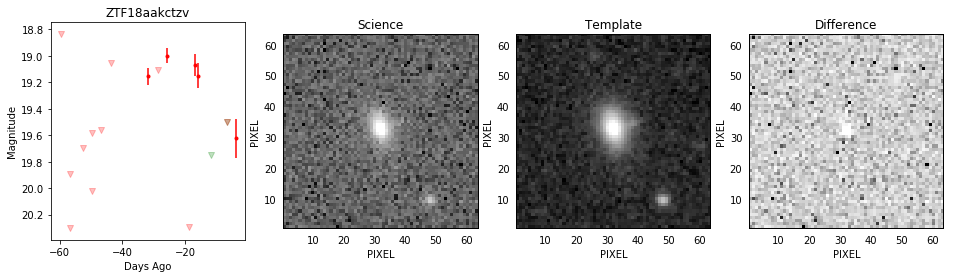

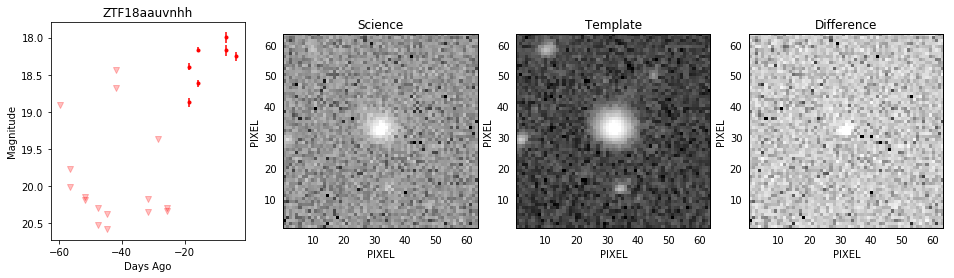

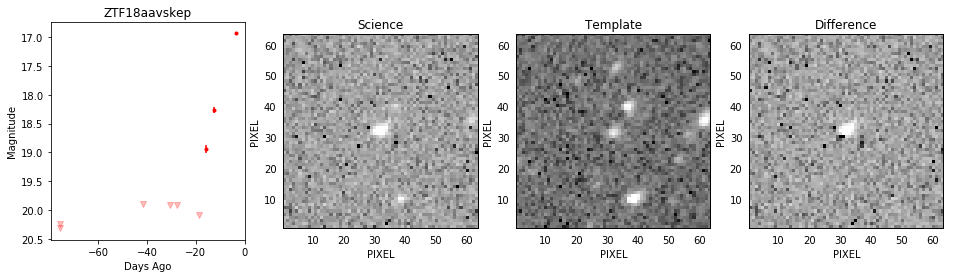

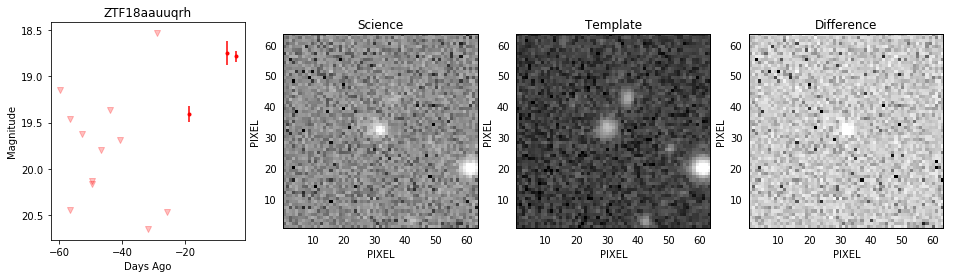

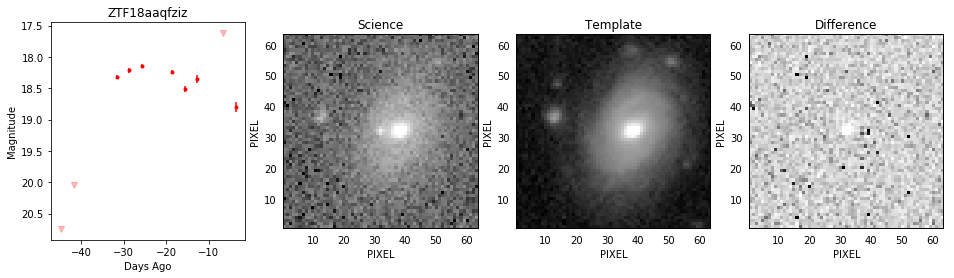

/Users/ebellm/anaconda3/envs/zads/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


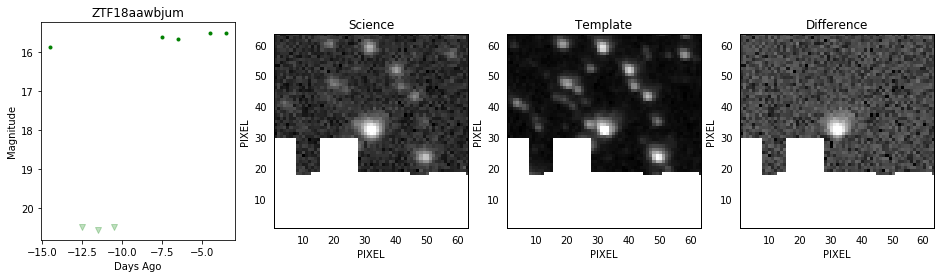

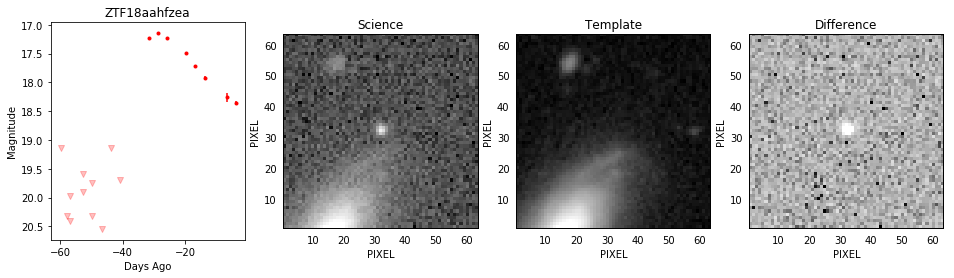

In [17]:
for packet in transient_alerts:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        show_all(packet)